In [284]:
import pickle

# load the scenario properties file
with open('../scenario-properties-collision.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

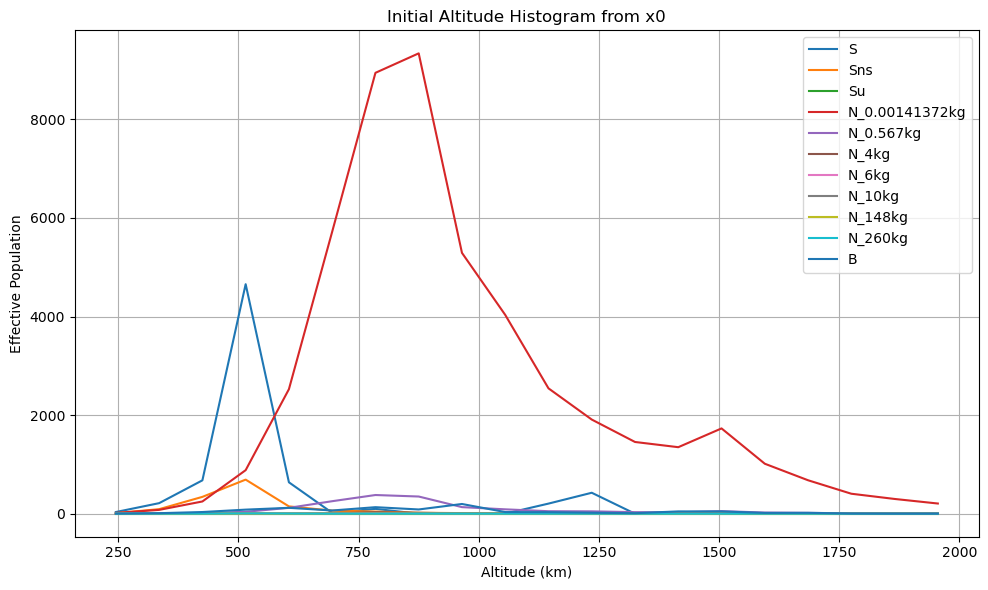

In [285]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Plot: One line per species ---
plt.figure(figsize=(10, 6))
for s in range(n_species):
    plt.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

plt.xlabel("Altitude (km)")
plt.ylabel("Effective Population")
plt.title("Initial Altitude Histogram from x0")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')  # Log scale for better visibility
plt.show()

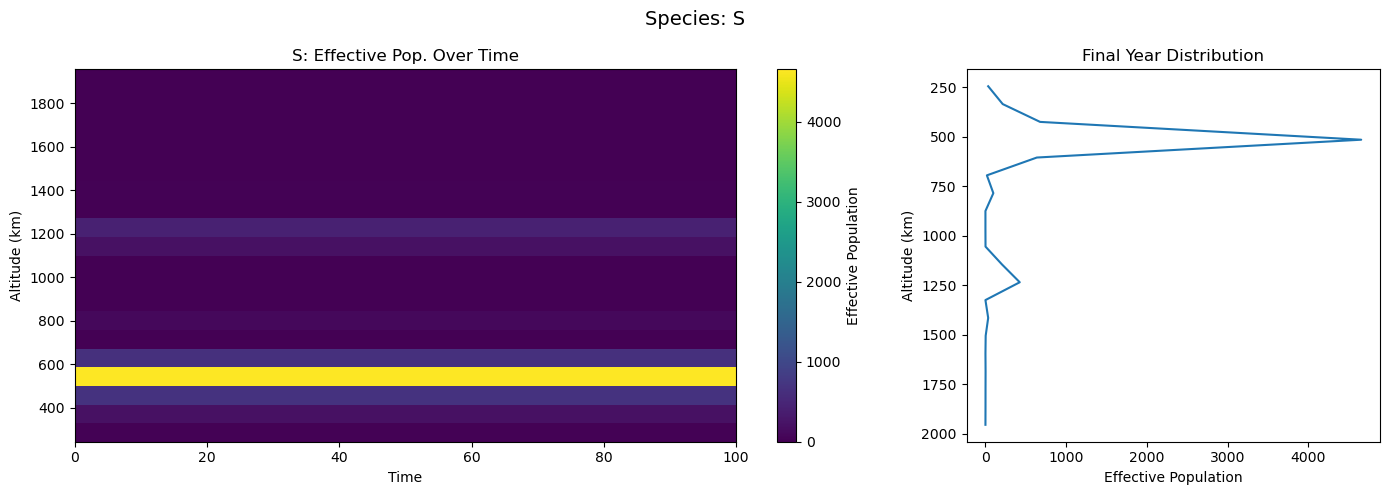

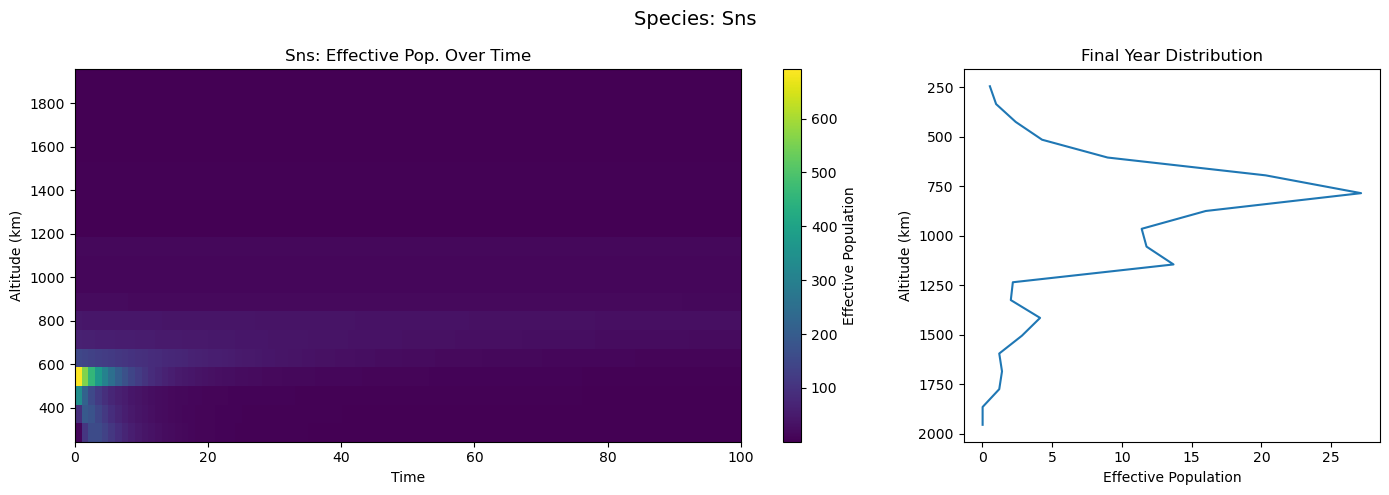

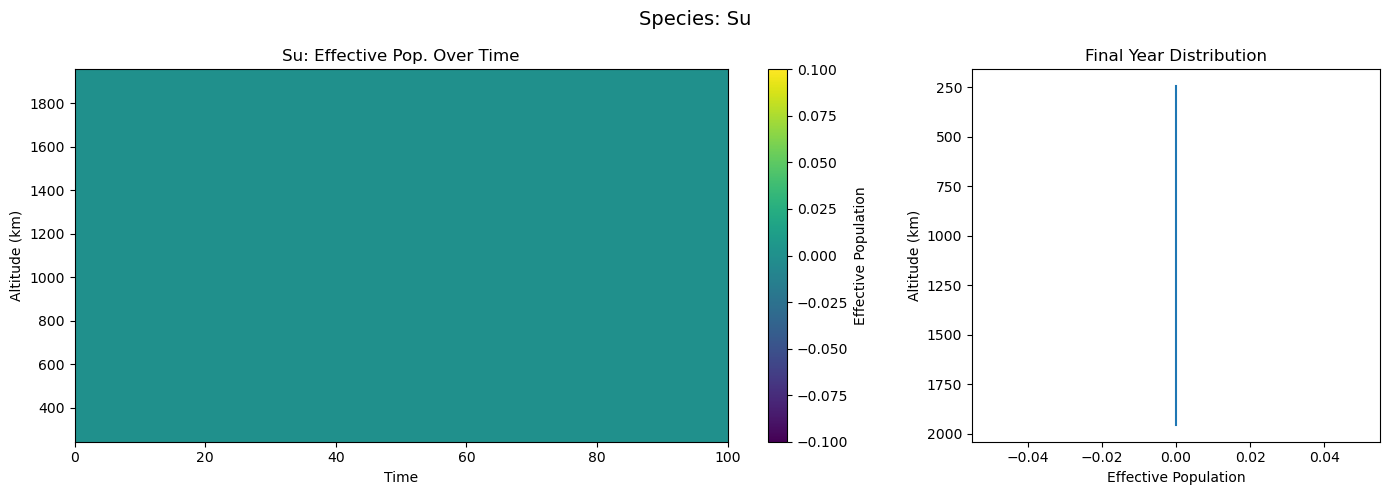

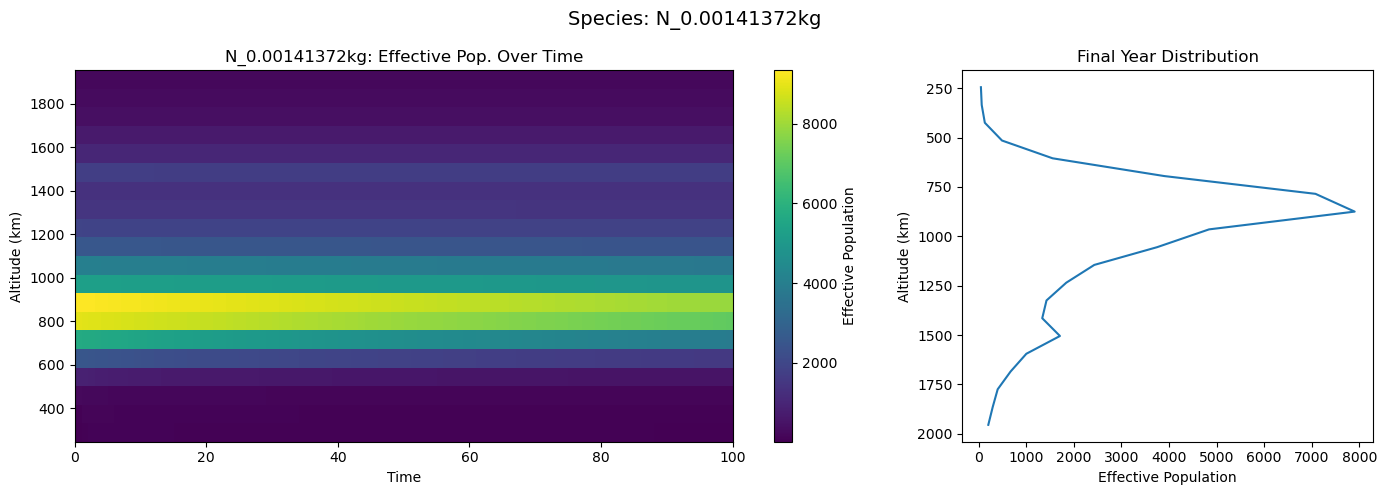

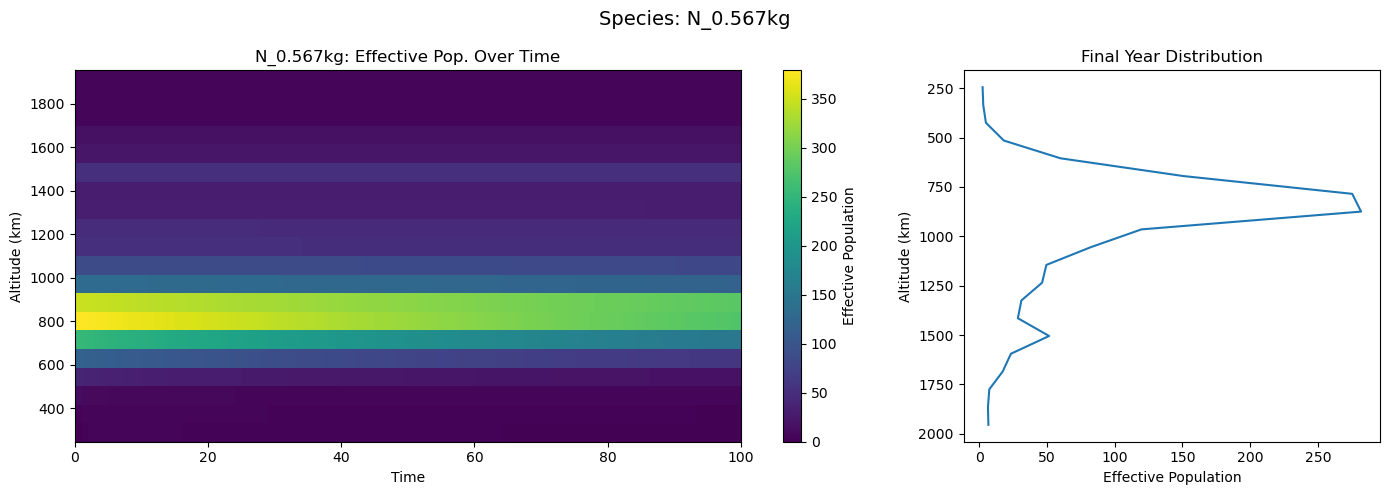

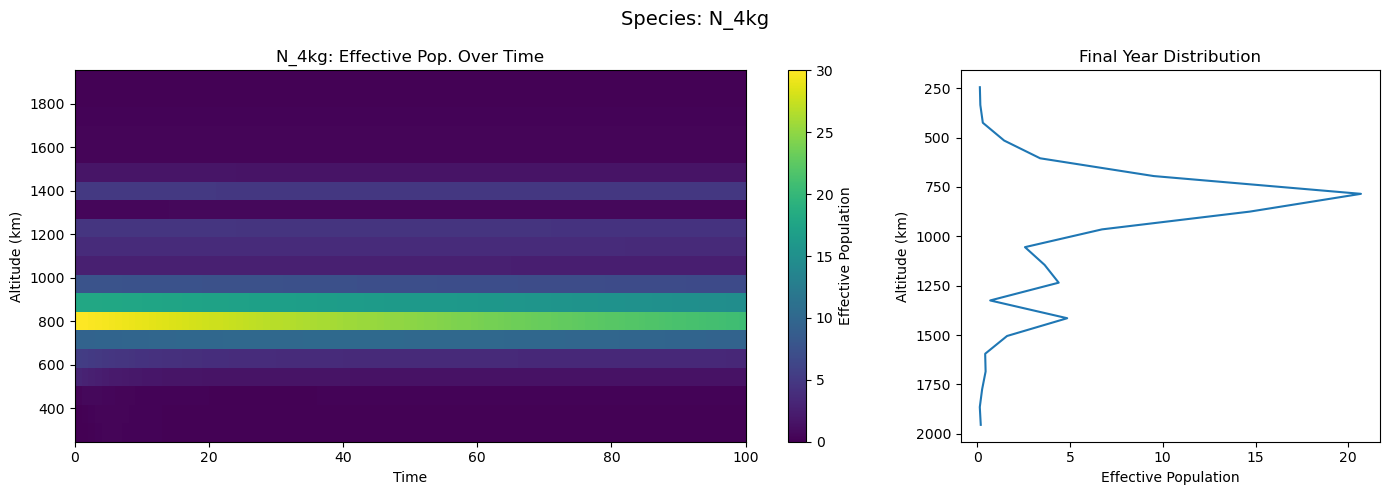

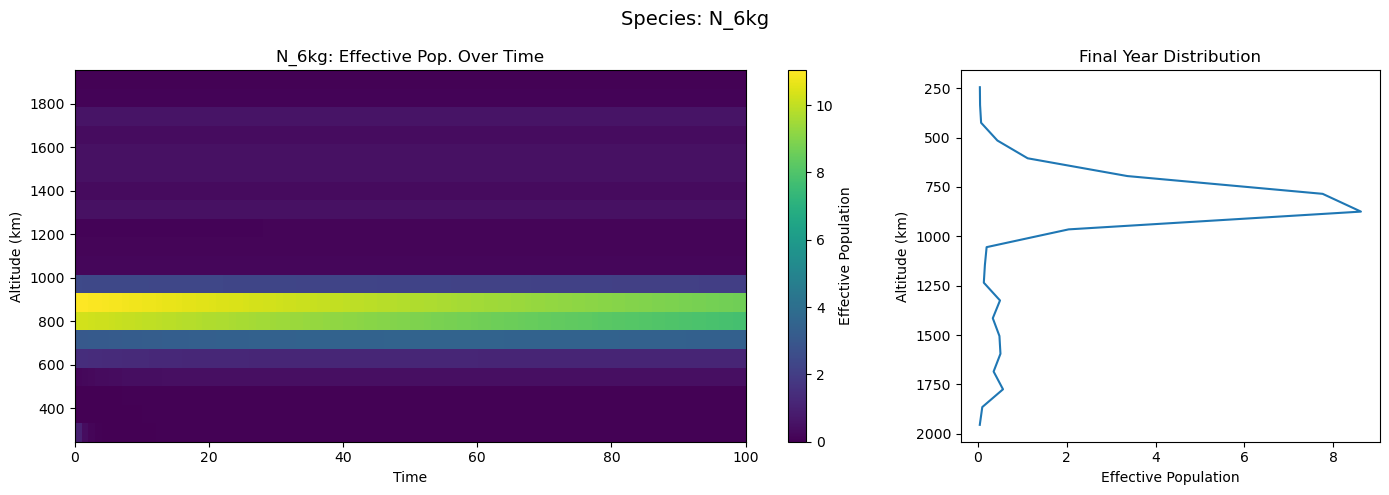

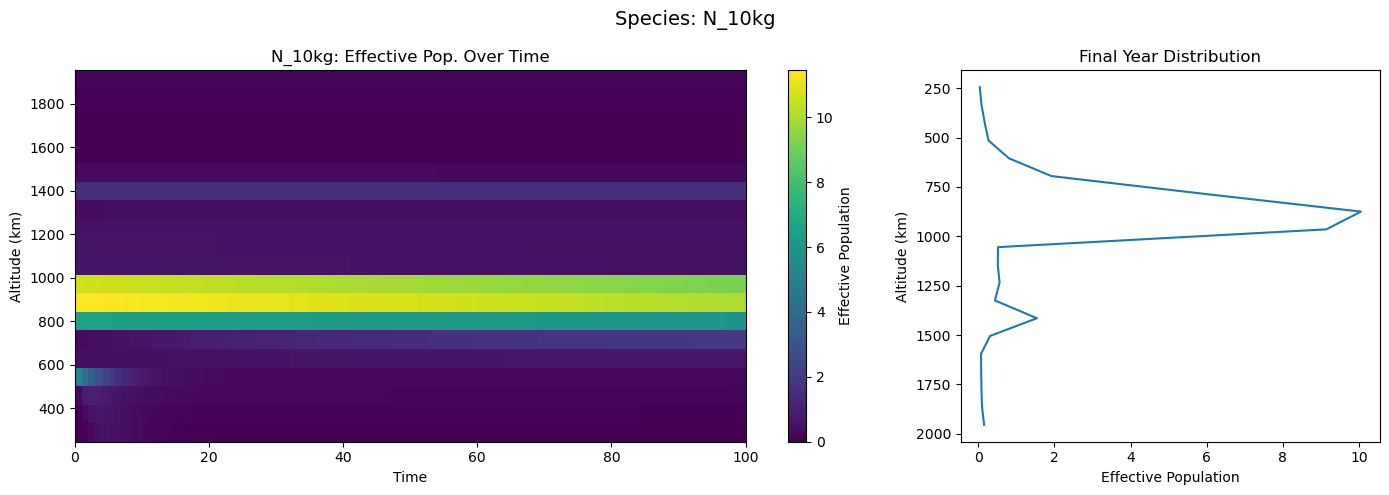

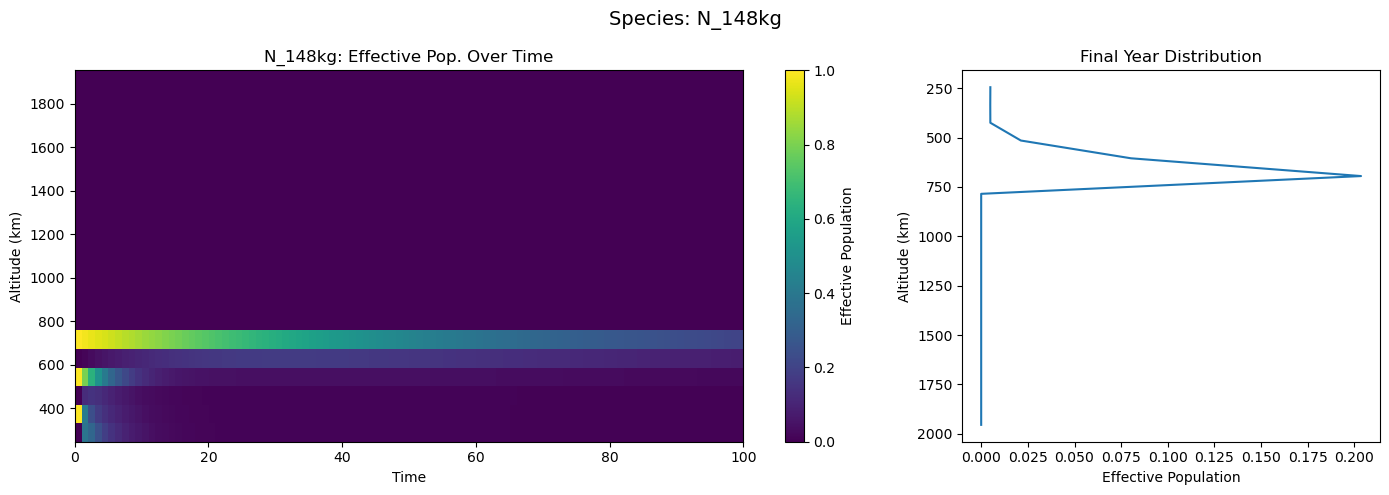

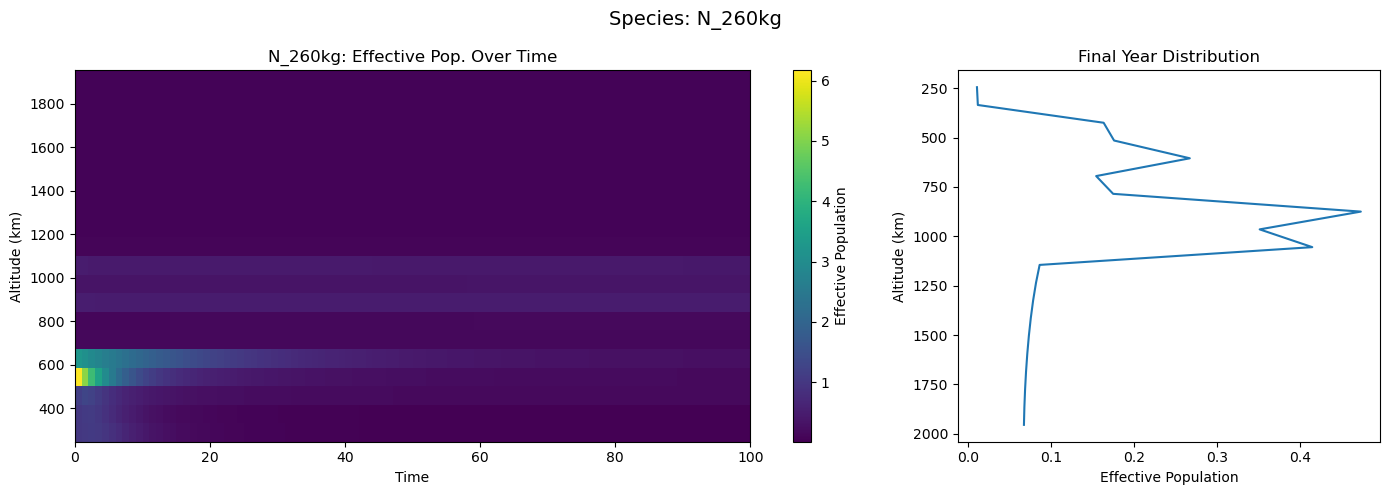

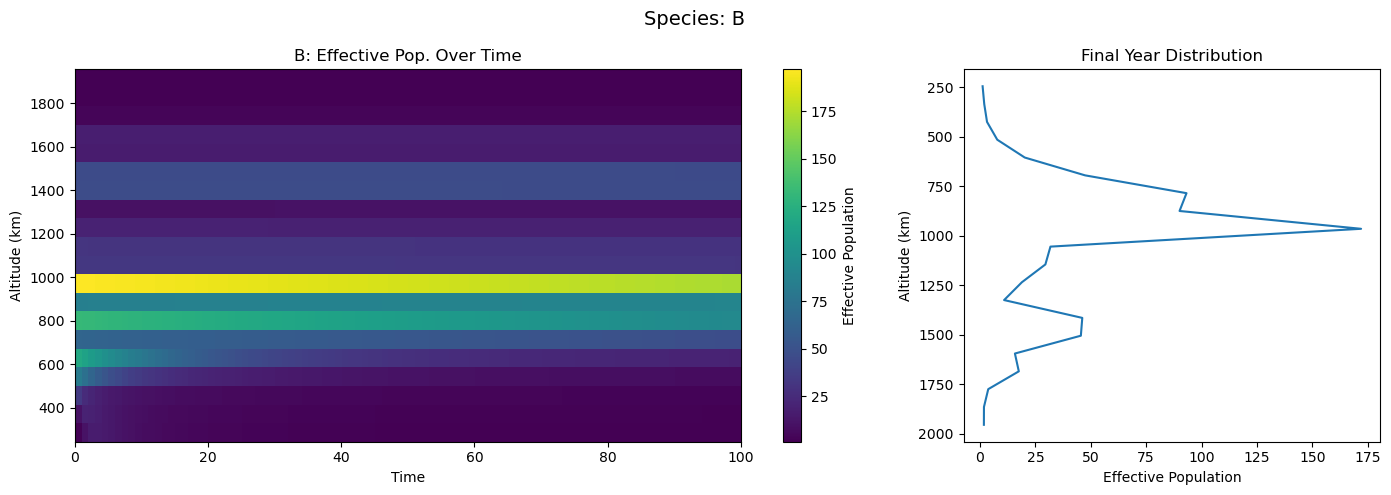

In [286]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_alt_shells = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
n_time = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # Altitude midpoints

# --- Unpack population data ---
y = scenario_properties.output.y
x_matrix = y.reshape(n_sma_bins, n_species, n_ecc_bins, n_time)  # shape: (sma, species, ecc, time)

# === Plotting ===
for s in range(n_species):
    n_eff_time = np.zeros((n_alt_shells, n_time))  # Altitude shells × time

    for t in range(n_time):
        pop_snapshot = x_matrix[:, s, :, t]  # shape: (sma, ecc)
        
        # Reconstruct full shape (sma, species, ecc) to use in converter
        pop_full = np.zeros((n_sma_bins, n_species, n_ecc_bins))
        pop_full[:, s, :] = pop_snapshot

        # Convert to altitude matrix using your method
        alt_proj = scenario_properties.sma_ecc_mat_to_altitude_mat(pop_full)
        n_eff_time[:, t] = alt_proj[:, s]

    # Final year distribution
    final_year_dist = n_eff_time[:, -1]

    # --- Create subplot: Heatmap + Final Distribution ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [2, 1]})

    # Left: Heatmap of effective population over time
    im = axes[0].imshow(n_eff_time, aspect='auto', origin='lower',
                        extent=[times[0], times[-1], altitudes[0], altitudes[-1]],
                        cmap='viridis')
    axes[0].set_title(f"{species_names[s]}: Effective Pop. Over Time")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Altitude (km)")
    plt.colorbar(im, ax=axes[0], label="Effective Population")

    # Right: Final year distribution
    axes[1].plot(final_year_dist, altitudes)
    axes[1].set_title("Final Year Distribution")
    axes[1].set_xlabel("Effective Population")
    axes[1].set_ylabel("Altitude (km)")
    axes[1].invert_yaxis()

    plt.suptitle(f"Species: {species_names[s]}", fontsize=14)
    plt.tight_layout()
    plt.show()

# Effective Altitude

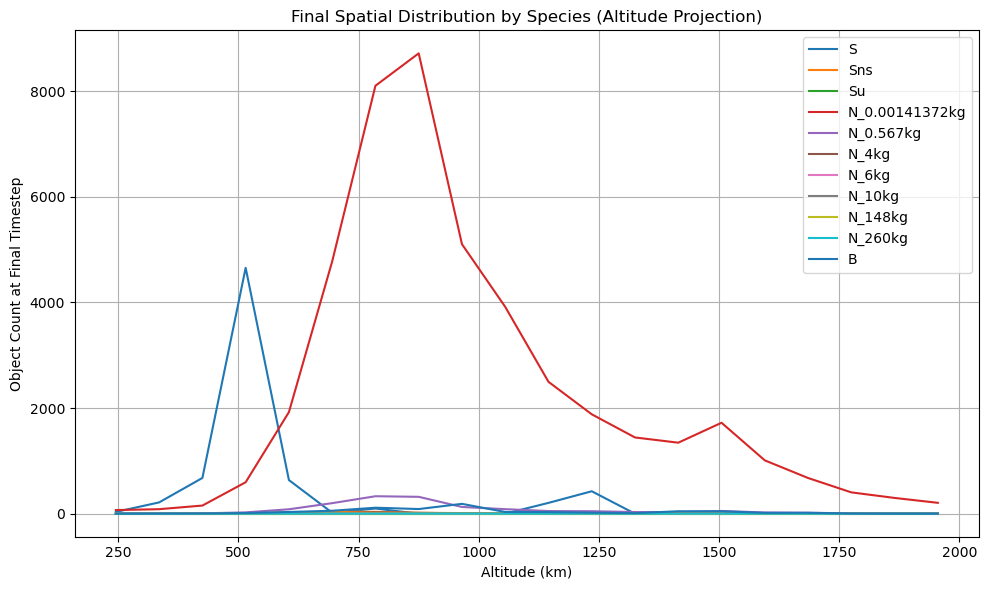

In [287]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack dimensions
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # shape: (n_shells,)
final_step_index = 40 # last times÷tep

# Extract final timestep and reshape
y = scenario_properties.output.y
y_final = y[:, final_step_index]  # shape: (n_sma_bins * n_species * n_ecc_bins,)

# Reshape to (sma, species, ecc)
x_matrix = y_final.reshape((n_sma_bins, n_species, n_ecc_bins))

# Project to altitude using provided method
x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (n_shells, n_species)

# === Plot: Total Altitude Distribution per Species ===
plt.figure(figsize=(10, 6))

for i in range(n_species):
    plt.plot(altitudes, x_alt[:, i], label=species_names[i])

plt.xlabel("Altitude (km)")
plt.ylabel("Object Count at Final Timestep")
plt.title("Final Spatial Distribution by Species (Altitude Projection)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

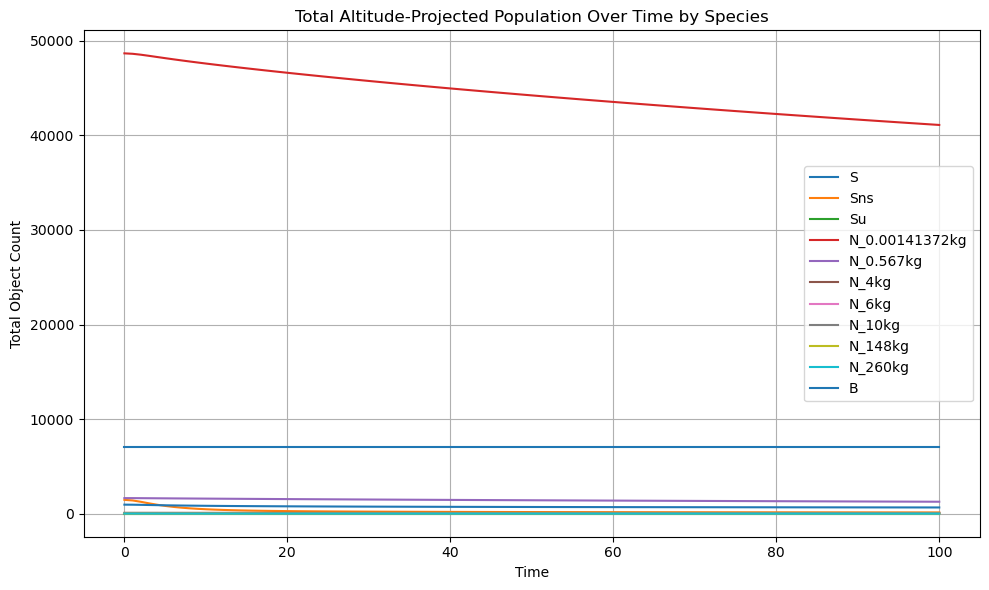

In [288]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid  # (n_shells,)
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t  # shape: (n_timesteps,)

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))  # shape: (species, time)

# --- Loop over each time step ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]  # shape: (n_sma_bins * n_species * n_ecc_bins,)
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))  # reshape to (sma, species, ecc)
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)  # shape: (alt_shells, species)

    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)  # total per species

# --- Plot ---
plt.figure(figsize=(10, 6))
for i in range(n_species):
    plt.plot(times, species_totals_over_time[i], label=species_names[i])

plt.xlabel("Time")
plt.ylabel("Total Object Count")
plt.title("Total Altitude-Projected Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

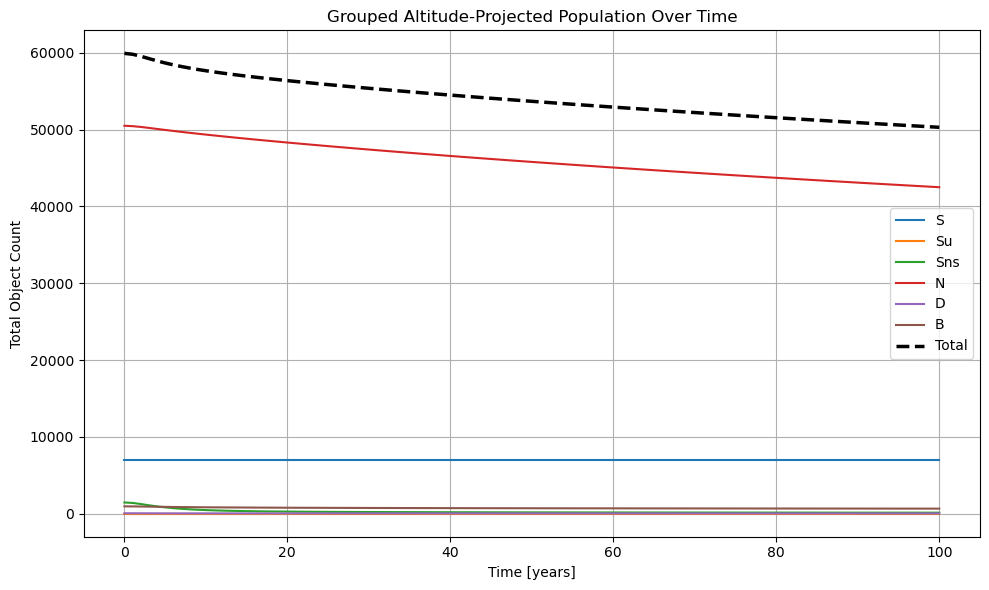

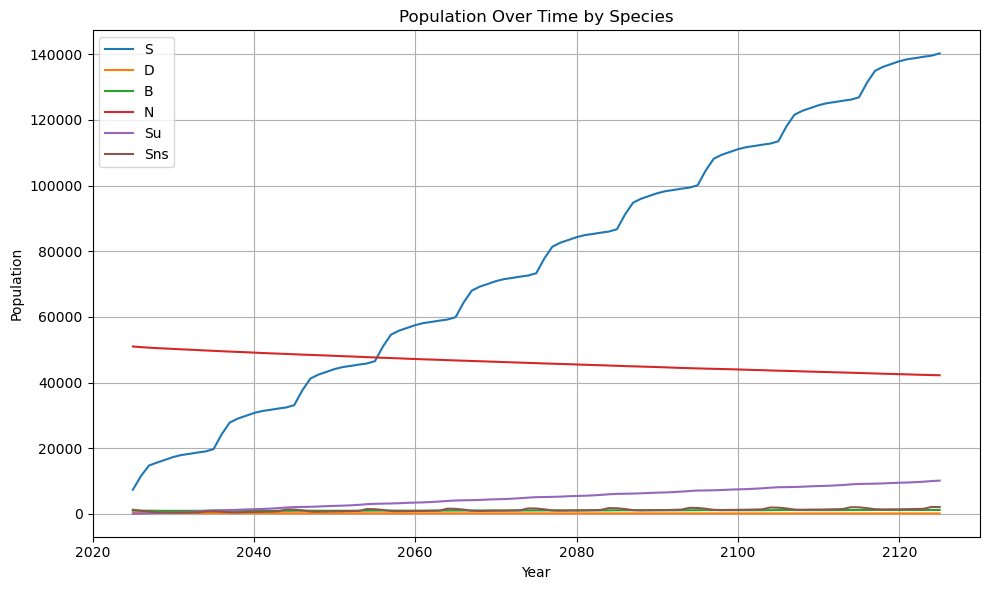

# COMPARISON TO MC

## Initial Population

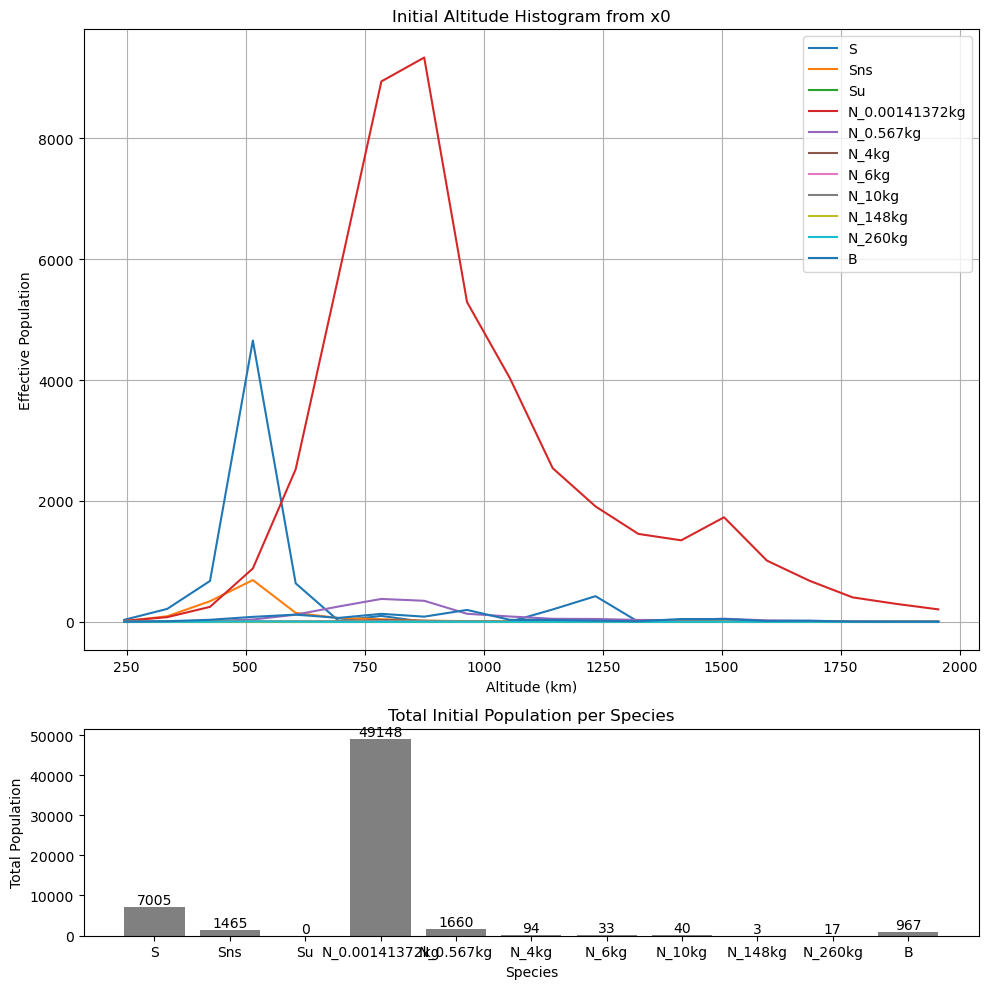

In [299]:
import numpy as np
import matplotlib.pyplot as plt

# Unpack inputs
x0 = scenario_properties.x0  # shape: (sma, species, ecc)
TIS = scenario_properties.time_in_shell  # shape: (altitude, ecc, sma)
altitudes = scenario_properties.HMid  # length: n_alt_shells
species_names = scenario_properties.species_names

n_sma_bins, n_species, n_ecc_bins = x0.shape
n_alt_shells = TIS.shape[0]

# --- Calculate effective population in each altitude shell per species ---
effective_altitude_matrix = np.zeros((n_alt_shells, n_species))

for species in range(n_species):
    for alt_shell in range(n_alt_shells):
        total = 0.0
        for sma in range(n_sma_bins):
            for ecc in range(n_ecc_bins):
                n_pop = x0[sma, species, ecc]
                tis = TIS[alt_shell, ecc, sma]
                total += n_pop * tis
        effective_altitude_matrix[alt_shell, species] = total

# --- Calculate total initial population per species ---
total_species_population = x0.sum(axis=(0, 2))

# --- Plot Setup ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), gridspec_kw={'height_ratios': [3, 1]})

# --- Plot: One line per species (Altitude distribution) ---
for s in range(n_species):
    ax1.plot(altitudes, effective_altitude_matrix[:, s], label=species_names[s])

ax1.set_xlabel("Altitude (km)")
ax1.set_ylabel("Effective Population")
ax1.set_title("Initial Altitude Histogram from x0")
ax1.legend()
ax1.grid(True)

# --- Histogram of total population per species ---
bars = ax2.bar(species_names, total_species_population, color='grey')

ax2.set_xlabel("Species")
ax2.set_ylabel("Total Population")
ax2.set_title("Total Initial Population per Species")

# --- Annotate actual numbers on bars ---
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [291]:
scenario_properties.x0[:, 1, :].sum()

1465

## FLM Difference to MC

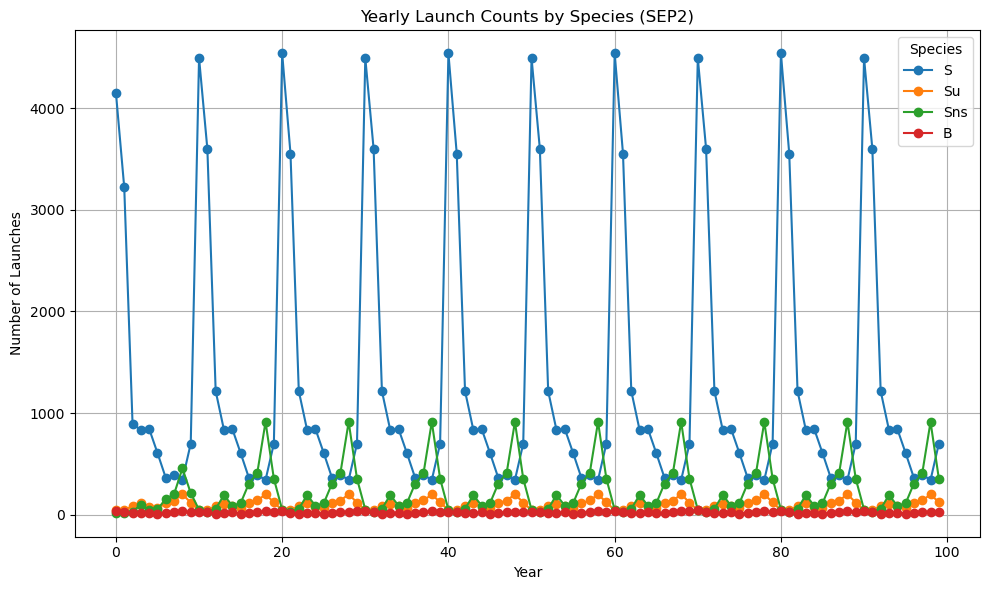

In [292]:
# Load CSV data
df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')

# Filter relevant species
species_of_interest = ['S', 'Su', 'Sns', 'B']
df_filtered = df[df['Species'].isin(species_of_interest)]

# Pivot table to have Years as index and Species as columns
pivot_df = df_filtered.pivot(index='Year', columns='Species', values='Launch_Count')

# Plot comparison
plt.figure(figsize=(10, 6))
for species in species_of_interest:
    if species in pivot_df:
        plt.plot(pivot_df.index, pivot_df[species], marker='o', label=species)

plt.xlabel('Year')
plt.ylabel('Number of Launches')
plt.title('Yearly Launch Counts by Species (SEP2)')
plt.legend(title='Species')
plt.grid(True)
plt.tight_layout()
plt.show()

In [293]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums ---
diff = pyss - mc
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Create 4x2 subplot grid ---
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for i, sp in enumerate(target_species):
    ax_diff = axes[i, 0]
    ax_cum  = axes[i, 1]
    
    # Difference plot
    ax_diff.plot(diff.index, diff[sp], marker='o')
    ax_diff.axhline(0, color='black', linewidth=0.8)
    ax_diff.set_title(f"{sp}: pySSEM − MOCAT-MC")
    ax_diff.set_ylabel('Difference')
    ax_diff.grid(True)
    
    # Cumulative plot
    ax_cum.plot(cum_pyss.index, cum_pyss[sp],  label='pySSEM')
    ax_cum.plot(cum_mc.index,   cum_mc[sp],   label='MOCAT-MC')
    ax_cum.set_title(f"{sp}: Cumulative Launches")
    ax_cum.legend()
    ax_cum.grid(True)

# Common X label
for ax in axes[-1, :]:
    ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

# --- Combined cumulative plot for all species ---
plt.figure(figsize=(10, 6))
for sp in target_species:
    plt.plot(cum_pyss.index, cum_pyss[sp],label=f"pySSEM {sp}")
    plt.plot(cum_mc.index,   cum_mc[sp],  linestyle='--', label=f"MOCAT-MC {sp}")

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
plt.title('Cumulative Launches by Species: pySSEM vs MOCAT-MC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


AttributeError: 'NoneType' object has no attribute 'groupby'

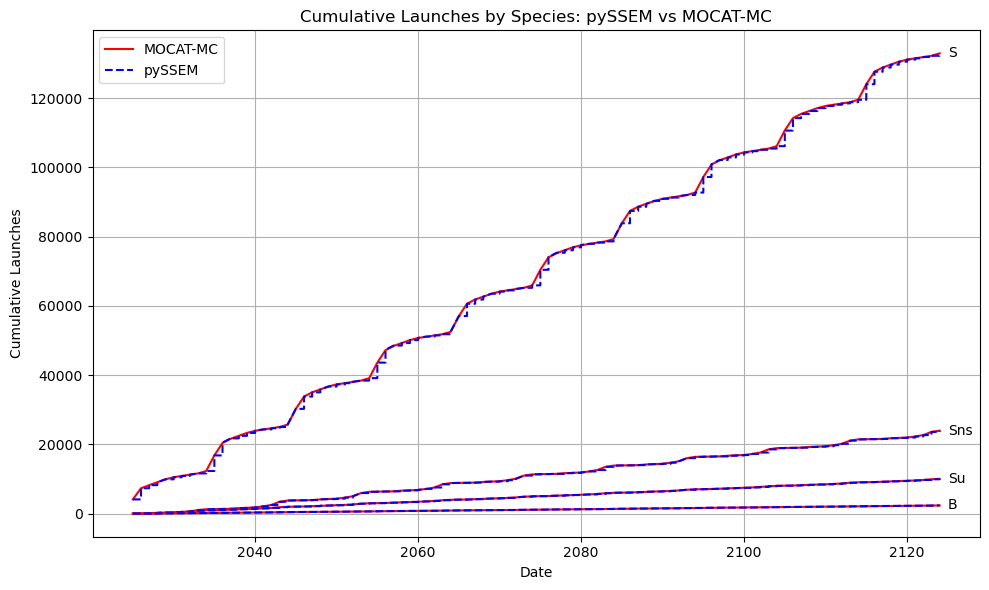

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute cumulative sums ---
cum_pyss = pyss.cumsum()
cum_mc   = mc.cumsum()

# --- Combined cumulative plot ---
plt.figure(figsize=(10, 6))

# Model-level colors
py_color = 'blue'
mc_color = 'red'

for sp in target_species:
    # MOCAT-MC solid thick
    plt.plot(cum_mc.index, cum_mc[sp],
             linestyle='-', color=mc_color)
        # pySSEM dashed
    plt.plot(cum_pyss.index, cum_pyss[sp],
             linestyle='--', color=py_color)

# Annotate species names at final point (using MOCAT-MC values)
x_last = cum_mc.index[-1] + pd.Timedelta(days=365)  # offset 1 year to the right
for sp in target_species:
    y_last = cum_mc[sp].iloc[-1]
    plt.text(x_last, y_last, sp, va='center')

# Legend with only model names
from matplotlib.lines import Line2D
legend_handles = [
    Line2D([0], [0], color=mc_color, label='MOCAT-MC'),
    Line2D([0], [0], color=py_color, linestyle='--', label='pySSEM')
]
plt.legend(handles=legend_handles, loc='upper left')

plt.xlabel('Date')
plt.ylabel('Cumulative Launches')
plt.title('Cumulative Launches by Species: pySSEM vs MOCAT-MC')
plt.grid(True)
plt.tight_layout()
plt.show()

## Difference with Np.interp

In [ ]:
import pandas as pd

# List of species
target_species = ["S", "Sns", "Su", "B"]

# --- pySSEM time series ---
pyss_df = (
    scenario_properties.FLM_steps
    .groupby("epoch_start_date")[target_species]
    .sum()
)
pyss_df.index = pd.to_datetime(pyss_df.index)

# --- MOCAT-MC (SEP2) time series ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_df['Date'] = pd.to_datetime(mc_df['Year'] + 2025, format='%Y')
mc_ts = (
    mc_df.pivot(index='Date', columns='Species', values='Launch_Count')
         .reindex(columns=target_species)
         .sort_index()
)

# --- Align both series on a common index ---
common_index = pyss_df.index.union(mc_ts.index)
pyss = pyss_df.reindex(common_index).fillna(0)
mc   = mc_ts.reindex(common_index).fillna(0)

# --- Compute difference and cumulative sums by species ---
diff       = pyss - mc
cum_diff   = diff.cumsum()

# --- Total cumulative difference across species at each time ---
total_cum_diff = cum_diff.sum(axis=1)

# --- Final cumulative difference over entire scenario ---
final_diff = total_cum_diff.iloc[-1]
print(f"Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: {final_diff}")

# Optional: cumulative difference time series
# total_cum_diff.plot(title='Total Cumulative Difference Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Difference')
# plt.grid(True)
# plt.show()

Cumulative difference (pySSEM − MOCAT-MC) at end of scenario: 0.0


# OVerall Population Difference SSEM/MC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Dimensions ---
n_sma_bins = scenario_properties.n_shells
n_species = scenario_properties.species_length
n_ecc_bins = len(scenario_properties.eccentricity_bins) - 1
species_names = scenario_properties.species_names
altitudes = scenario_properties.HMid
n_timesteps = scenario_properties.output.y.shape[1]
times = scenario_properties.output.t

# --- Initialize storage ---
y = scenario_properties.output.y
species_totals_over_time = np.zeros((n_species, n_timesteps))

# --- Project and sum over altitudes ---
for t_idx in range(n_timesteps):
    y_t = y[:, t_idx]
    x_matrix = y_t.reshape((n_sma_bins, n_species, n_ecc_bins))
    x_alt = scenario_properties.sma_ecc_mat_to_altitude_mat(x_matrix)
    species_totals_over_time[:, t_idx] = np.sum(x_alt, axis=0)

# --- Define groupings ---
large_fragments = ['N_10kg', 'N_148kg', 'N_260kg', 'N_472kg', 'N_750kg', 'N_1250kg']
group_indices = {
    'S':   [i for i, sp in enumerate(species_names) if sp == 'S'],
    'Su':  [i for i, sp in enumerate(species_names) if sp == 'Su'],
    'Sns': [i for i, sp in enumerate(species_names) if sp == 'Sns'],
    'N':   [i for i, sp in enumerate(species_names) if sp.startswith('N')],
    'D':   [i for i, sp in enumerate(species_names) if sp in large_fragments],
    'B':   [i for i, sp in enumerate(species_names) if sp == 'B']
}

# --- Compute grouped totals ---
group_totals = {group: np.sum(species_totals_over_time[indices], axis=0)
                for group, indices in group_indices.items()}

# --- Plot ---
plt.figure(figsize=(10, 6))
for group, values in group_totals.items():
    plt.plot(times, values, label=group)
plt.plot(times, np.sum(species_totals_over_time, axis=0), label="Total", linewidth=2.5, linestyle='--', color='black')

plt.xlabel("Time [years]")
plt.ylabel("Total Object Count")
plt.title("Grouped Altitude-Projected Population Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# load the MOCAT-MC data
import pandas as pd

mc_launch = '/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv'
mc_pop_time_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time.csv'
mc_pop_time_alt_path = '/Users/indigobrownhall/Code/MOCAT-VnV/results/pop_time_alt.csv'

mc_pop_time = pd.read_csv(mc_pop_time_path)

plt.figure(figsize=(10, 6))
for species in mc_pop_time["Species"].unique():
    species_df = mc_pop_time[mc_pop_time["Species"] == species]
    plt.plot(species_df["Year"], species_df["Population"], label=species)

plt.xlabel("Year")
plt.ylabel("Population")
plt.title("Population Over Time by Species")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.yscale('log')
plt.show()

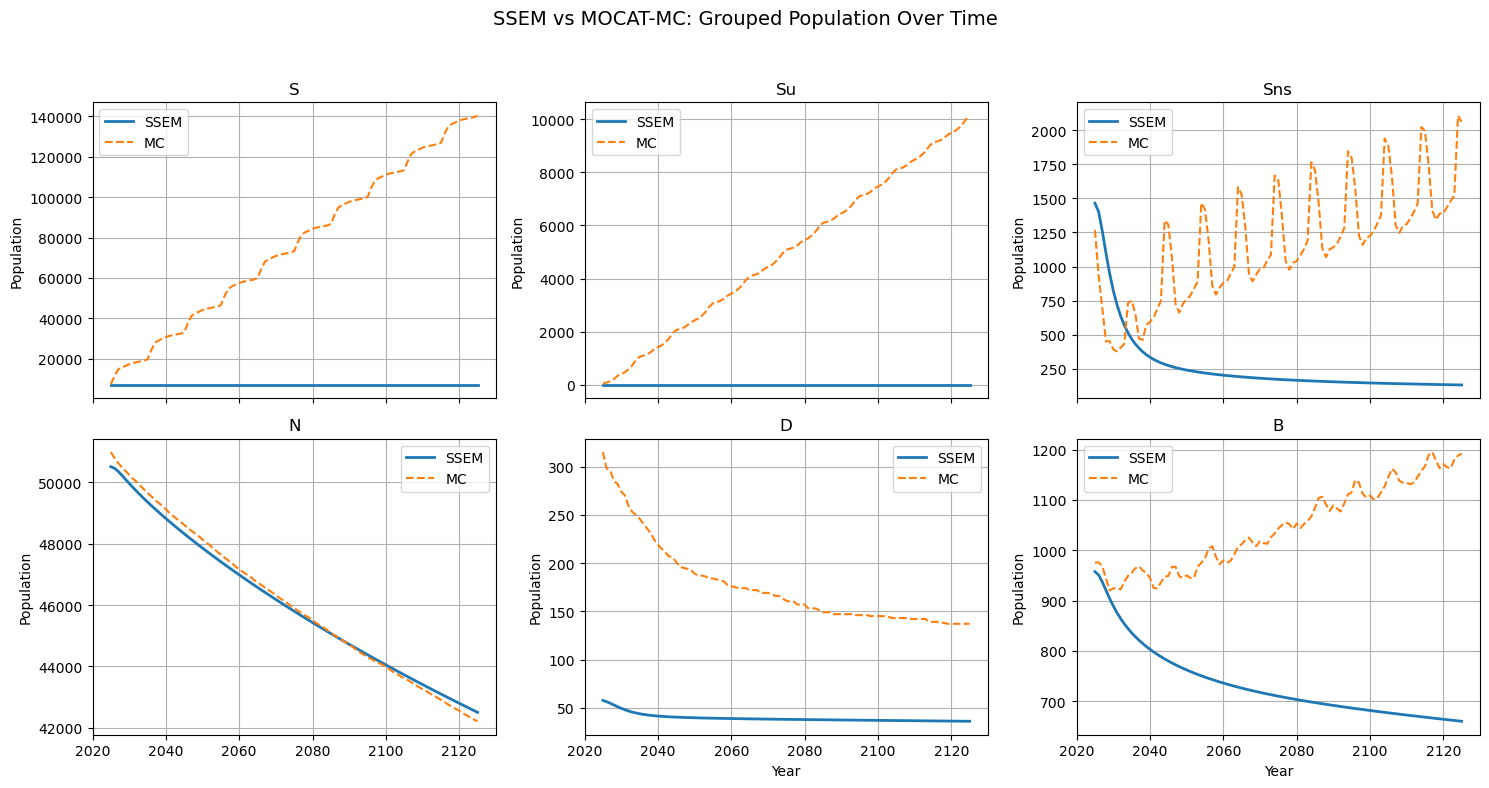

In [300]:
import matplotlib.pyplot as plt

# --- Species groups to compare ---
species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
n_rows, n_cols = 2, 3

start_year = 2025  # Or derive from scenario_properties.start_date
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group], label='SSEM', linewidth=2)

    # Plot MOCAT-MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.ticklabel_format(useOffset=False, axis='y')
# plt.xlim(2025,2045)
plt.show()

In [ ]:
group_totals['Sns']

array([1514.55545513, 1467.44122016, 1335.12563582, 1236.27420781,
       1152.56118144, 1046.85713281, 1029.28753531, 1070.94442739,
       1282.94179842, 1492.25707246, 1439.45386853, 1312.75160381,
       1199.24045076, 1203.91256618, 1233.24208391, 1192.75621267,
       1293.82443813, 1478.30432672, 1979.91801524, 2413.12660977,
       2281.71334306, 2033.50161457, 1817.45945955, 1736.7232995 ,
       1697.11431868, 1599.12858675, 1653.32182142, 1800.06827216,
       2269.75242885, 2674.10357883, 2519.95531413, 2253.8049574 ,
       2022.00850479, 1929.24411098, 1879.47575916, 1773.0397877 ,
       1819.67244649, 1958.65473725, 2424.58447305, 2827.29276538,
       2667.92081389, 2398.69793944, 2165.64888058, 2070.39969836,
       2017.96881841, 1908.33585568, 1952.48173599, 2090.93244288,
       2550.96333701, 2947.4915324 , 2787.51504518, 2515.30247699,
       2280.34840823, 2184.28163573, 2131.12901265, 2022.8436    ,
       2068.0506776 , 2206.14075609, 2666.68487503, 3064.10823

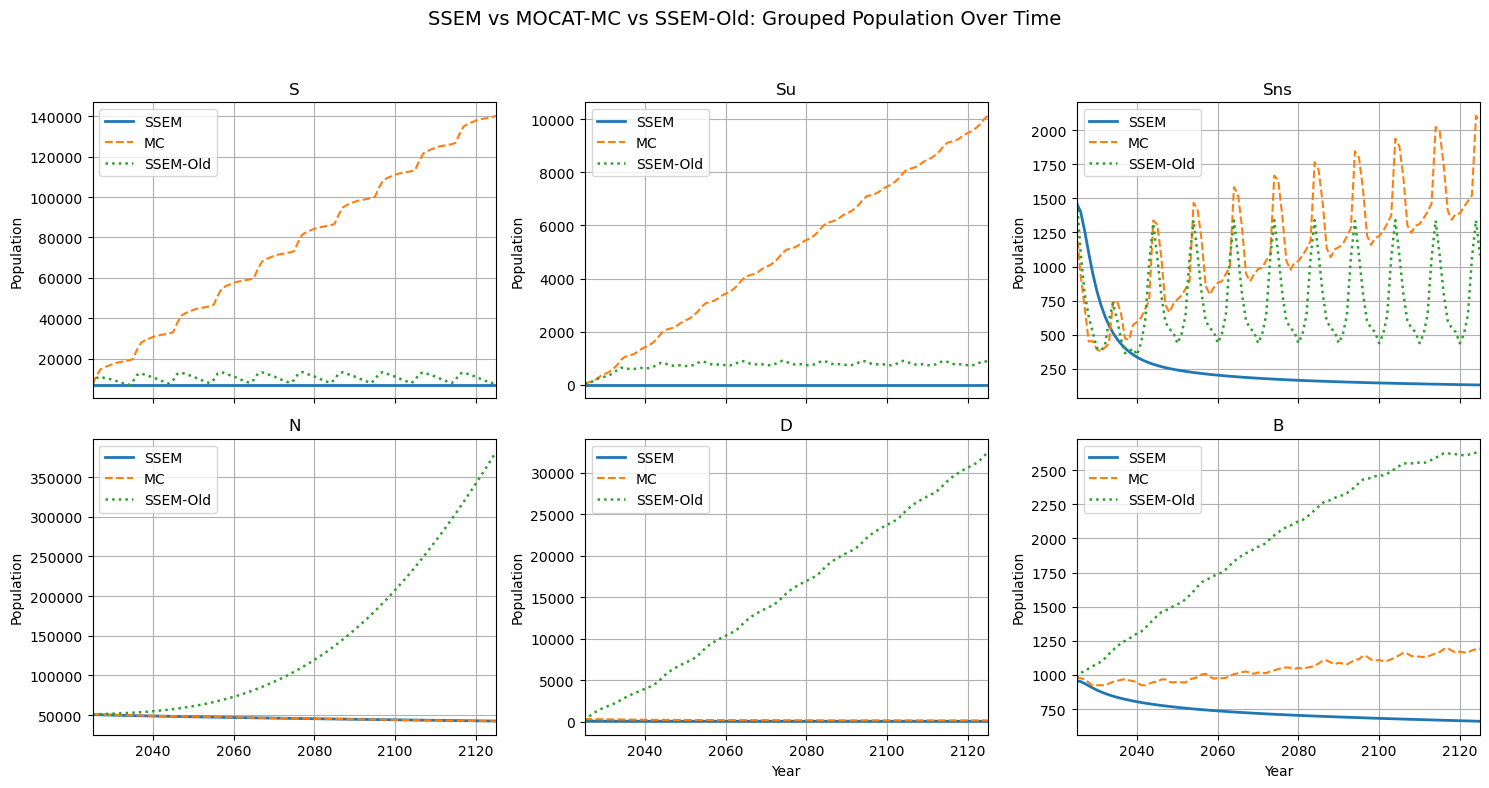

In [296]:
import pandas as pd
import matplotlib.pyplot as plt

# --- Load third dataset: SSEM-Old ---
ssem_old_path = "/Users/indigobrownhall/Code/pyssem/figures/SEP-Final-Runs/SEP2/pop_time.csv"
df_ssem_old = pd.read_csv(ssem_old_path)

# remove data where year is older than 2125
df_ssem_old = df_ssem_old[df_ssem_old["Year"] <= 2125]

# --- Species groups to compare ---
species_groups = ['S', 'Su', 'Sns', 'N', 'D', 'B']
n_rows, n_cols = 2, 3

# --- Time adjustment for SSEM ---
start_year = 2025
ssem_years = times + start_year

# --- Create subplot grid ---
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8), sharex=True)
axes = axes.flatten()

for idx, group in enumerate(species_groups):
    ax = axes[idx]
    
    # Plot SSEM (new)
    if group in group_totals:
        ax.plot(ssem_years, group_totals[group], label='SSEM', linewidth=2)

    # Plot MC
    if group in mc_pop_time["Species"].unique():
        mc_df = mc_pop_time[mc_pop_time["Species"] == group]
        ax.plot(mc_df["Year"], mc_df["Population"], '--', label='MC', linewidth=1.5)

    # Plot SSEM-Old
    if group in df_ssem_old["Species"].unique():
        old_df = df_ssem_old[df_ssem_old["Species"] == group]
        ax.plot(old_df["Year"], old_df["Population"], ':', label='SSEM-Old', linewidth=1.8)

    ax.set_title(group)
    ax.set_ylabel("Population")
    ax.grid(True)
    ax.legend()

# Add shared X labels
axes[-2].set_xlabel("Year")
axes[-1].set_xlabel("Year")

plt.suptitle("SSEM vs MOCAT-MC vs SSEM-Old: Grouped Population Over Time", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.xlim(2025, 2125)  # Adjust x-axis limits for better visibility
plt.show()

# Launch Functions

S: 130047 total launches
Sns: 24211 total launches
Su: 10136 total launches
N_0.00141372kg: 0 total launches
N_0.567kg: 0 total launches
N_4kg: 0 total launches
N_6kg: 0 total launches
N_10kg: 0 total launches
N_148kg: 0 total launches
N_260kg: 0 total launches
B: 2392 total launches
166786


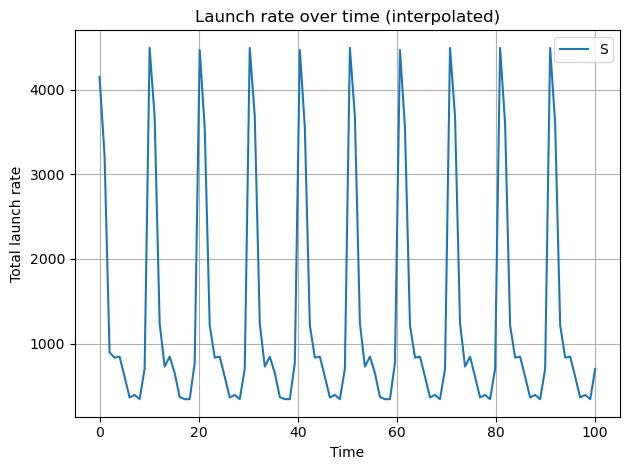

In [ ]:
from scipy.interpolate import interp1d

launch_rate_functions = np.full(
    (scenario_properties.n_sma_bins, n_species, scenario_properties.n_ecc_bins), 
    None, 
    dtype=object
)


if not scenario_properties.baseline:
    for sma in range(scenario_properties.n_sma_bins):
        for species in range(n_species):
            for ecc in range(scenario_properties.n_ecc_bins):
                rate_array = scenario_properties.full_lambda_flattened[sma, species, ecc]

                try:
                    # Default: no launch
                    launch_rate_functions[sma, species, ecc] = None

                    if rate_array is None:
                        continue

                    # Case 1: Clean array directly
                    if isinstance(rate_array, np.ndarray):
                        flattened_array = rate_array.astype(float)

                    # Case 2: Mixed list of array + zeros
                    elif isinstance(rate_array, list):
                        array_found = next((np.asarray(r).astype(float) for r in rate_array if isinstance(r, np.ndarray)), None)
                        if array_found is None:
                            continue
                        flattened_array = array_found

                    # Case 3: Scalar or unexpected input — skip
                    else:
                        continue

                    # Clean
                    flattened_array[np.isnan(flattened_array)] = 0
                    flattened_array[np.isinf(flattened_array)] = 0

                    # Validate
                    if flattened_array.shape[0] != len(scenario_properties.scen_times):
                        continue
                    if np.all(flattened_array == 0):
                        continue

                    # Interpolate
                    interp_func = interp1d(
                        scenario_properties.scen_times,
                        flattened_array,
                        kind='previous',  # or 'linear' if you're okay with smoothing
                        bounds_error=False,
                        fill_value=0
                    )
                    launch_rate_functions[sma, species, ecc] = interp_func

                except Exception as e:
                    raise ValueError(f"Failed processing rate_array at [sma={sma}, species={species}, ecc={ecc}]:\n{rate_array}\n\n{e}")
                
import numpy as np

# Get dimensions
n_sma_bins, n_species, n_ecc_bins = scenario_properties.x0.shape
scen_times = scenario_properties.scen_times
dt = np.diff(scen_times, prepend=scen_times[0])  # Time steps (e.g., in years)
species_names = scenario_properties.species_names

# Initialize total launches tracker per species
total_launches_per_species = np.zeros(n_species)

# Loop through all bins and accumulate launches
for sma in range(n_sma_bins):
    for species in range(n_species):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                try:
                    launch_rates = func(scen_times)  # Evaluate at all times
                    total = np.sum(launch_rates * dt)  # Integrate over time
                    total_launches_per_species[species] += total
                except Exception as e:
                    raise RuntimeError(
                        f"Failed evaluating launch_func at [sma={sma}, species={species}, ecc={ecc}]: {e}"
                    )

# Print totals

total_all = 0
for i, total in enumerate(total_launches_per_species):
    total_all += int(round(total))
    print(f"{species_names[i]}: {int(round(total))} total launches")

print(total_all)

import matplotlib.pyplot as plt

for species in [0]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

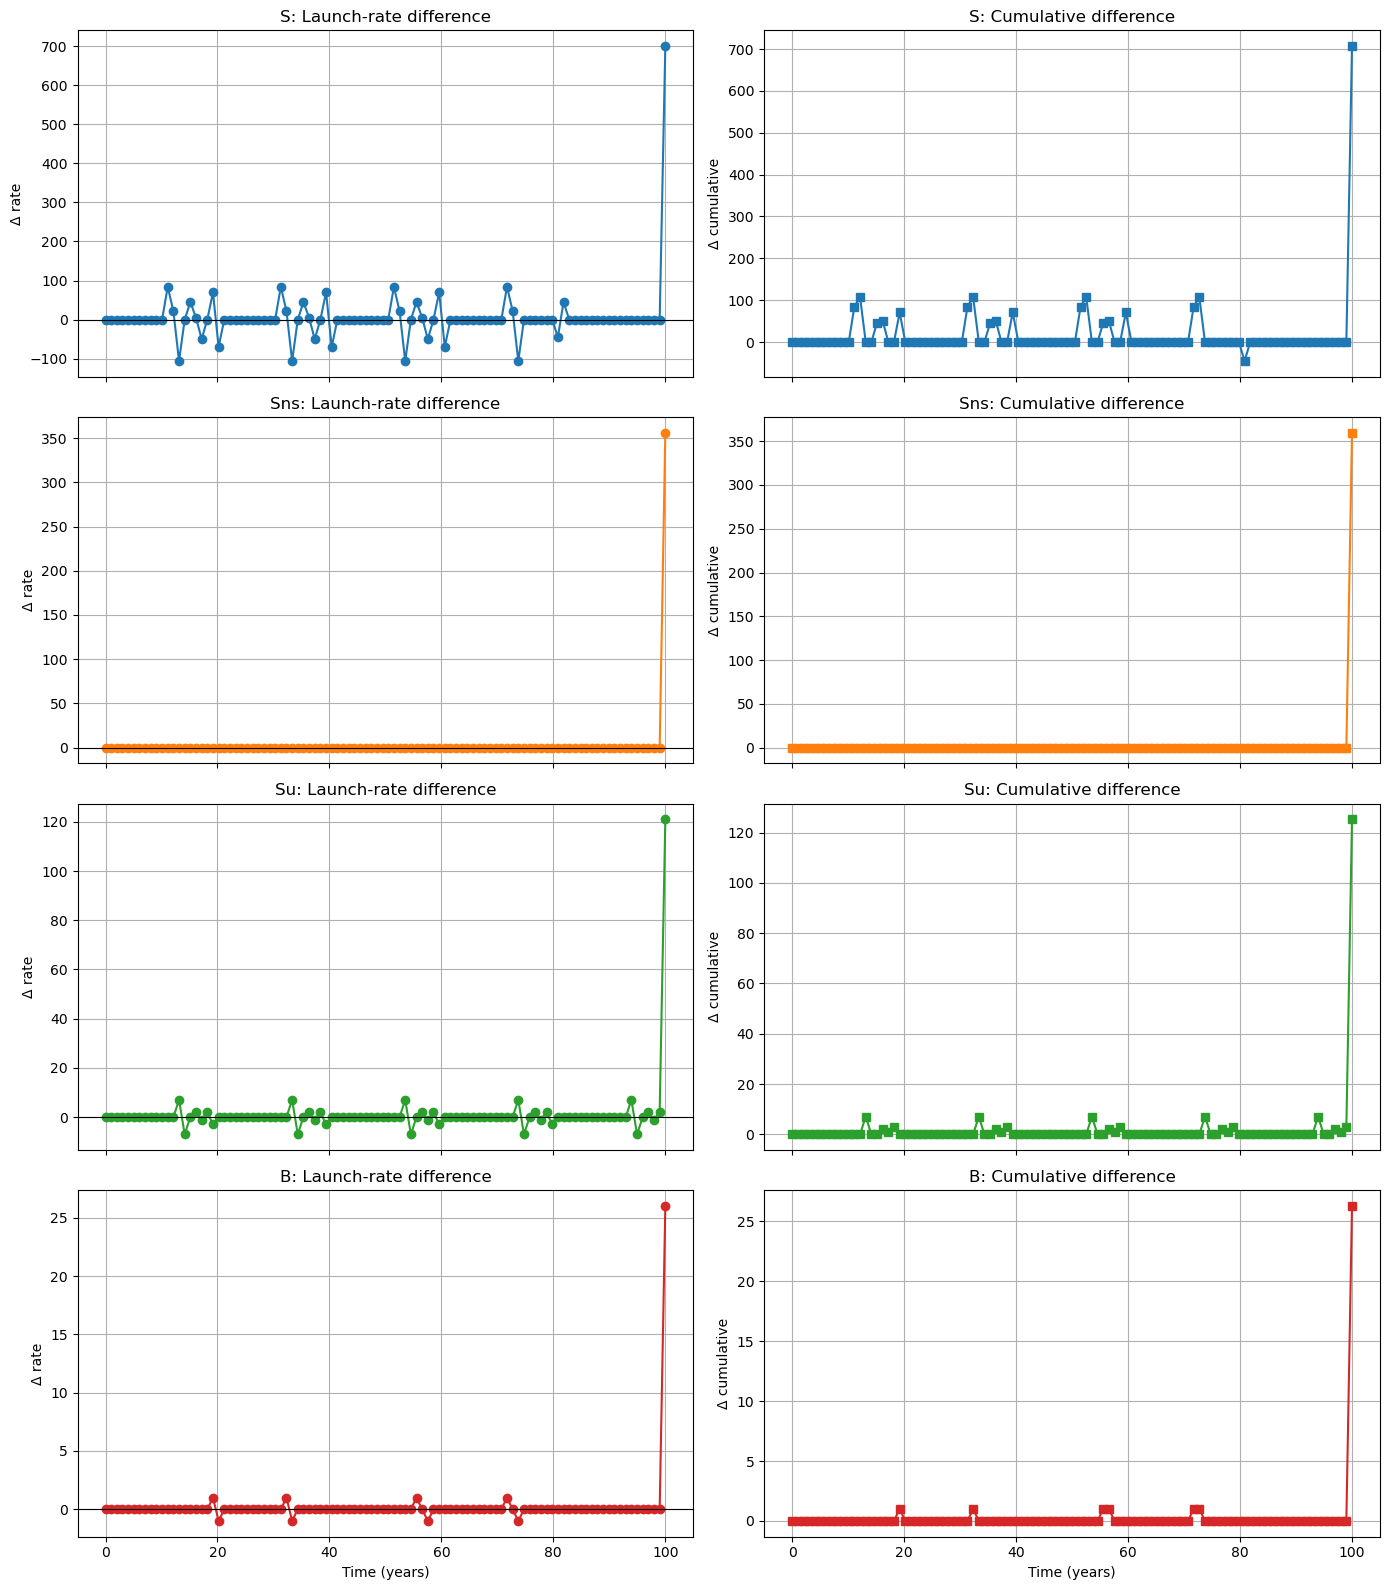

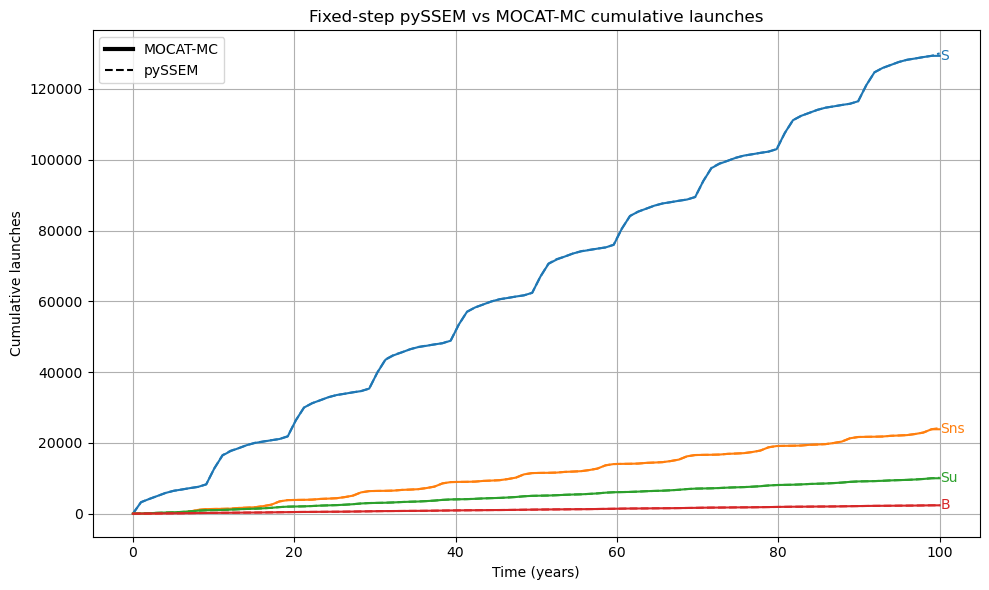

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# --- Parameters and data ---
scen_times = scenario_properties.scen_times  # numeric years since start
dt = np.diff(scen_times, prepend=scen_times[0])
n_sma, n_species, n_ecc = scenario_properties.x0.shape
species_names = scenario_properties.species_names
target_species = ["S", "Sns", "Su", "B"]

# --- Build MOCAT-MC (SEP2) interpolation functions using numeric years ---
mc_df = pd.read_csv('/Users/indigobrownhall/Code/MOCAT-VnV/yearly_launch_counts_SEP2.csv')
mc_pivot = mc_df.pivot(index='Year', columns='Species', values='Launch_Count')
years_unique = mc_pivot.index.values  # 0,1,2,... up to max year
mc_interp = {
    sp: interp1d(years_unique,
                 mc_pivot[sp].fillna(0).values,
                 kind='previous',
                 bounds_error=False,
                 fill_value=0)
    for sp in target_species
}

# Evaluate MC launch-rate at scen_times (numeric years)
rates_mc = {sp: mc_interp[sp](scen_times) for sp in target_species}

# --- Compute pySSEM fixed-step launch-rate time series ---
rates_pyss = {sp: np.zeros_like(scen_times) for sp in target_species}
for sma in range(n_sma):
    for i_sp, sp in enumerate(species_names):
        if sp in target_species:
            for ecc in range(n_ecc):
                func = launch_rate_functions[sma, i_sp, ecc]
                if func is not None:
                    rates_pyss[sp] += func(scen_times)

# --- Integrate to get cumulative launches ---
cum_pyss = {sp: np.cumsum(rates_pyss[sp] * dt) for sp in target_species}
cum_mc   = {sp: np.cumsum(rates_mc[sp]   * dt) for sp in target_species}

# --- Compute rate and cumulative differences ---
diff_rate = {sp: rates_pyss[sp] - rates_mc[sp] for sp in target_species}
cum_diff  = {sp: cum_pyss[sp] - cum_mc[sp]   for sp in target_species}

# --- 4×2 grid: rate difference (left) and cumulative difference (right) ---
colors = ['C0', 'C1', 'C2', 'C3']
fig, axes = plt.subplots(4, 2, figsize=(14, 16), sharex=True)
for idx, sp in enumerate(target_species):
    c = colors[idx]
    ax_rate = axes[idx, 0]
    ax_cum  = axes[idx, 1]

    ax_rate.plot(scen_times, diff_rate[sp], marker='o', color=c)
    ax_rate.axhline(0, color='black', linewidth=0.8)
    ax_rate.set_title(f"{sp}: Launch‐rate difference")
    ax_rate.set_ylabel("Δ rate")
    ax_rate.grid(True)

    ax_cum.plot(scen_times, cum_diff[sp], marker='s', color=c)
    ax_cum.set_title(f"{sp}: Cumulative difference")
    ax_cum.set_ylabel("Δ cumulative")
    ax_cum.grid(True)

for ax in axes[-1, :]:
    ax.set_xlabel("Time (years)")

plt.tight_layout()
plt.show()

# --- Combined cumulative launches plot with styling ---
plt.figure(figsize=(10, 6))
py_color = 'blue'
mc_color = 'red'
for idx, sp in enumerate(target_species):
    c = colors[idx]
    plt.plot(scen_times, cum_mc[sp], linestyle='-', color=c)
    plt.plot(scen_times, cum_pyss[sp], linestyle='--', color=c)

# Annotate species names at final point
x_off = scen_times[-1] + (scen_times[-1] - scen_times[-2]) * 0.1
for idx, sp in enumerate(target_species):
    y = cum_mc[sp][-1]
    plt.text(x_off, y, sp, va='center', color=colors[idx])

from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], color='black', lw=3, label='MOCAT-MC'),
    Line2D([0], [0], color='black', lw=1.5, linestyle='--', label='pySSEM')
]
plt.legend(handles=handles, loc='upper left')

plt.xlabel("Time (years)")
plt.ylabel("Cumulative launches")
plt.title("Fixed‐step pySSEM vs MOCAT-MC cumulative launches")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Get dimensions
n_sma_bins, n_species, n_ecc_bins = scenario_properties.x0.shape
scen_times = scenario_properties.scen_times
dt = np.diff(scen_times, prepend=scen_times[0])  # Time steps (e.g., in years)
species_names = scenario_properties.species_names

# Initialize total launches tracker per species
total_launches_per_species = np.zeros(n_species)

# Loop through all bins and accumulate launches
for sma in range(n_sma_bins):
    for species in range(n_species):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                try:
                    launch_rates = func(scen_times)  # Evaluate at all times
                    total = np.sum(launch_rates * dt)  # Integrate over time
                    total_launches_per_species[species] += total
                except Exception as e:
                    raise RuntimeError(
                        f"Failed evaluating launch_func at [sma={sma}, species={species}, ecc={ecc}]: {e}"
                    )

# Print totals

total_all = 0
for i, total in enumerate(total_launches_per_species):
    total_all += int(round(total))
    print(f"{species_names[i]}: {int(round(total))} total launches")

print(total_all)

S: 130047 total launches
Sns: 24211 total launches
Su: 10136 total launches
N_0.00141372kg: 0 total launches
N_0.567kg: 0 total launches
N_4kg: 0 total launches
N_6kg: 0 total launches
N_10kg: 0 total launches
N_148kg: 0 total launches
N_260kg: 0 total launches
B: 2392 total launches
166786


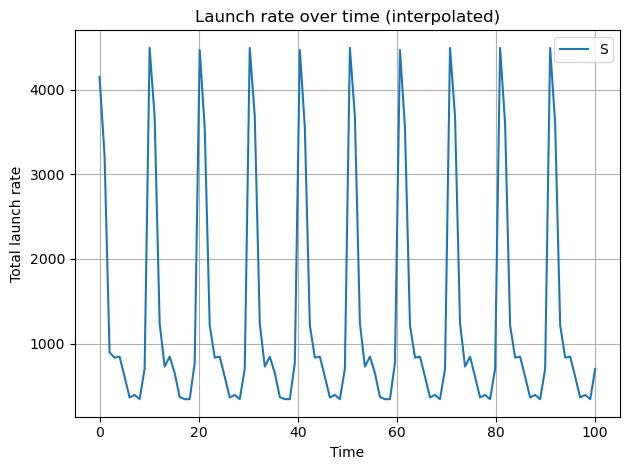

In [ ]:
import matplotlib.pyplot as plt

for species in [0]:  # index for S as an example
    flat_launch = np.zeros_like(scenario_properties.scen_times)

    for sma in range(n_sma_bins):
        for ecc in range(n_ecc_bins):
            func = launch_rate_functions[sma, species, ecc]
            if func is not None:
                flat_launch += func(scenario_properties.scen_times)

    plt.plot(scenario_properties.scen_times, flat_launch, label=species_names[species])

plt.xlabel("Time")
plt.ylabel("Total launch rate")
plt.title("Launch rate over time (interpolated)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

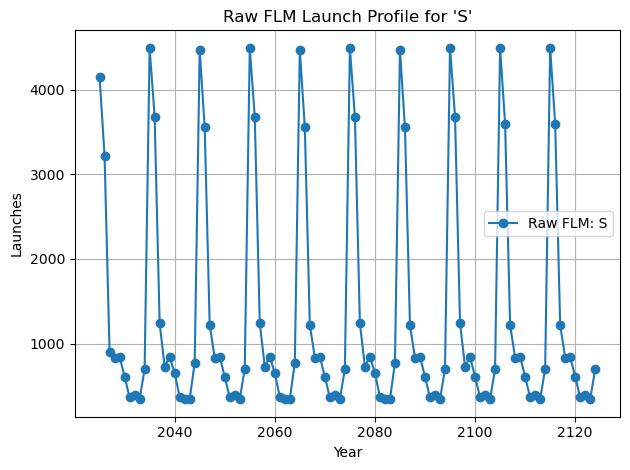

In [ ]:
import pandas as pd

# Convert datetime to float years relative to start of scenario
reference_date = scenario_properties.scen_times[0]  # should already be a float year
S_launch = scenario_properties.FLM_steps.groupby('epoch_start_date')['S'].sum()

# Convert datetime to pandas datetime
datetime_index = pd.to_datetime(S_launch.index)
# Convert to float years (e.g., 2025.0, 2025.5)
float_years = datetime_index.year + (datetime_index.dayofyear - 1) / 365.25

# Now assign index
S_launch.index = float_years

# Plot
import matplotlib.pyplot as plt
plt.plot(S_launch.index, S_launch.values, label='Raw FLM: S', marker='o')
plt.xlabel("Year")
plt.ylabel("Launches")
plt.title("Raw FLM Launch Profile for 'S'")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

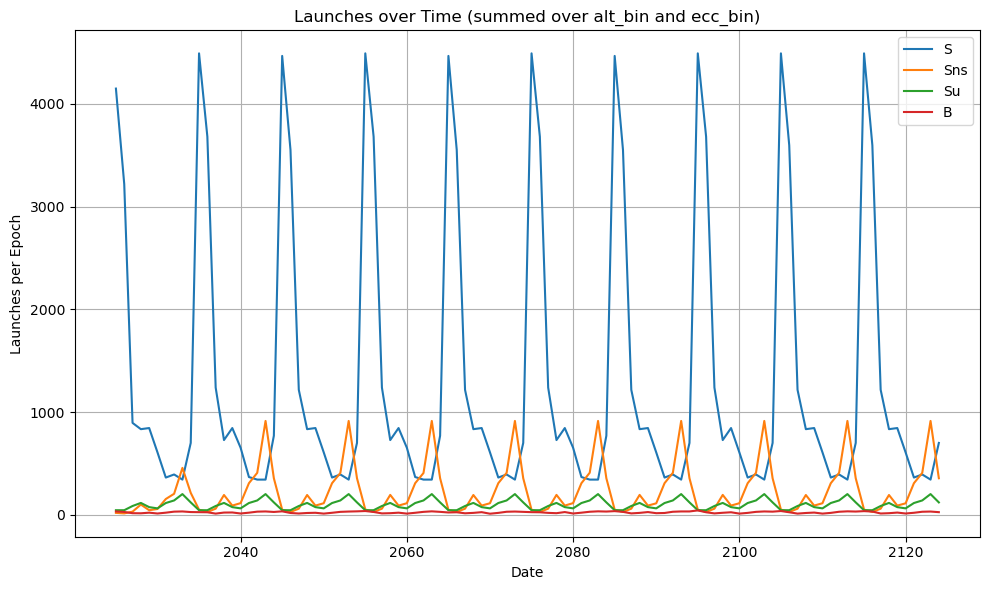

In [ ]:
import matplotlib.pyplot as plt

# List of species to plot
target_species = ["S", "Sns", "Su", "B"]

# Group and sum over all alt_bin and ecc_bin
grouped = scenario_properties.FLM_steps.groupby("epoch_start_date")[target_species].sum()

# Plotting
plt.figure(figsize=(10, 6))
for species in target_species:
    plt.plot(grouped.index, grouped[species], label=species)

plt.xlabel("Date")
plt.ylabel("Launches per Epoch")
plt.title("Launches over Time (summed over alt_bin and ecc_bin)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
for species_index, species_name in enumerate(scenario_properties.species_names):
    print(species_index, species_name)

0 S
1 Sns
2 Su
3 N_0.00141372kg
4 N_0.567kg
5 N_4kg
6 N_6kg
7 N_10kg
8 N_148kg
9 N_260kg
10 B


In [ ]:
count = 0
for i in scenario_properties.full_lambda_flattened:
    try:
        count += i.sum()
    except:
        continue

print(count.sum())

169366
